In [745]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
import pandas as pd
import lasagne
import theano.tensor as T
%load_ext autoreload
%autoreload 2
 
import importlib
import pickle
from utils.result_utils import *
root = '/Users/thorey/Documents/project/competition/fognet/models/clavius/lstm'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Artifical data 

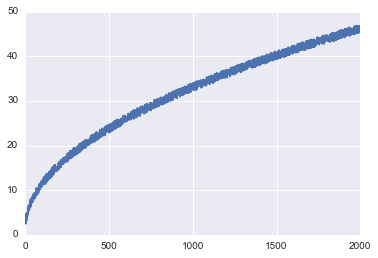

In [505]:
xa = np.arange(1,2000,1)
xb = np.sqrt(np.arange(1,2000,1))
x = np.vstack((xa,xb)).T
y = np.sqrt(xa+xb)+2*np.random.rand(x.shape[0])
plt.plot(xa,y)

In [671]:
# On creer un index pour le temps
rng = pd.date_range('1/1/2011', periods=x.shape[0], freq='2H')
# On crer le data frame
data = pd.DataFrame(x,index= rng,columns=['xa','xb'])
data['y'] = y
# We select som part of the data to mimic the pred set, where we don't know y
rand_nan = list(np.random.randint(1999,size=10))
for nan in rand_nan:
    data.loc[nan:nan+10,'y'] = -1

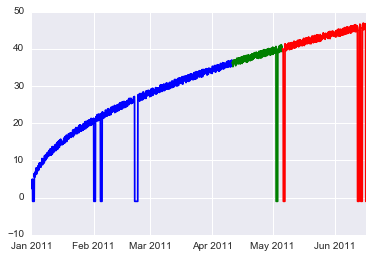

In [672]:
# Make train,val,test
train,val,test = data.iloc[:1200],data.iloc[1200:1500],data.iloc[1500:]
plt.plot(train['y'],color ='b')
plt.plot(val['y'],color ='g')
plt.plot(test['y'],color ='r')

In [673]:
class BaseBatchIterator(object):

    '''
    Class to proceed from the dataframe to batch of data to be
    feed in the rnn
    At prediction time, each batch correspond to the number of
    sample in the group.

    '''

    def __init__(self, feats=[], label='y', batch_size=25, size_seq=25, stride=1, verbose=False):
        # feature to take from the dataframe
        self.feats = feats
        self.nfeats = len(feats)
        # Target
        self.label = label
        # Size of the sequence you want to enroll in the rnn
        self.seq_size = size_seq
        # Stride for the construction of the sequence.
        # For instance, if we have [xa,xb,xc,xd,xe,xf] where each x is a D-dimensional vector.
        # A stride of 2 with a size_seq of 4, willr etuyrn [[xa,xb,xc,xd],[xc,xd,xe,xf]]
        # Looks like a conv 1D !
        self.stride = stride
        # Size of the batch to process each step of the gradient update
        self.batch_size = batch_size
        self.verbose = False

    def __call__(self, df):
        self.df = df
        self.stack_seqs = self.stack_sequence()
        return self

    def stack_sequence(self):
        '''
        This function allows to take the training dataframe, and
        return a dict of (X,y) tupple. Each key correspond to a
        different group - define above. Each group is consituted by a
        continuous sequence of observation (2H lags).
        For each group, we input a dataframe of size (N,D). N obs/ D features.
        We then build sequence of observation from it. A trivial
        way to do it is to take df.iloc[0:seq_size],df.iloc[seq_size:2seq_size]
        and so on.

        However, we proceed as for a 1D convolution. For instance,
        if we have [xa,xb,xc,xd,xe,xf] where each x is a D-dimensional vector.
        The X, for a stride of 2 with a size_seq of 4, should be [[xa,xb,xc,xd],[xc,xd,xe,xf]].
        The number of sequence is given by the simple formula
        n_sequences = (N-seq_size)/stride +1

        '''
        # The input dataframe is basically (N,D) dimensional tensor.
        # N is the number of obs
        # D is the number of feature to consider !
        # Initialize a dict to store (X,y)
        seq_size = self.seq_size
        nb_obs = len(self.df)
        # Nb of sequences
        nb_seqs = (nb_obs - seq_size) / self.stride + 1
        # Begin of the processing
        gp = self.df
        X = np.zeros((nb_seqs, seq_size, self.nfeats))
        y = np.zeros((nb_seqs, seq_size))
        mask_y = np.zeros((nb_seqs,seq_size))
        idx_y = np.zeros((nb_seqs, seq_size))
        for k in range(nb_seqs):
            kmin = k * self.stride  # lower bound window
            kmax = k * self.stride + seq_size  # Upper boud window
            X[k, :, :] = np.array(gp[self.feats].iloc[kmin:kmax])
            y[k, :] = np.array(gp[self.label].iloc[kmin:kmax])
            
            idx_y[k, :] = map(int, range(kmin, kmax))
        # At the end, X has a shape (N,T,D)
        # y has a shape (N,T)
        return (X, y)

    def __iter__(self):
        # Iterator
        (X, y) =self.stack_sequence()
        n_samples = X.shape[0]
        bs = self.batch_size
        n_batches = (n_samples + bs - 1) // bs
        idx = range(len(X))
        for i in range(n_batches):
            sl = slice(i * bs, (i + 1) * bs)
            Xb = X[idx[sl]]
            yb = y[idx[sl]]
            yield self.transform(Xb, yb)

    @property
    def n_samples(self):
        X = self.X
        if isinstance(X, dict):
            return len(list(X.values())[0])
        else:
            return len(X)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state


In [674]:
N_BATCH = 25
MAX_LENGTH = 200
iter_kwargs = dict(feats=['xa','xb'],
                   label='y',
                   batch_size=N_BATCH,
                   size_seq=MAX_LENGTH,
                   stride=1)
batch_ite_train = BaseBatchIterator(**iter_kwargs)(train)
batch_ite_val = BaseBatchIterator(**iter_kwargs)(val)
batch_ite_test = BaseBatchIterator(**iter_kwargs)(test)

# Net 

In [679]:
D =2 
H=20
grad_clip = 10

l_in = lasagne.layers.InputLayer(name='in',
                                     shape=(None, None, D))
batchsize, seqlen, _ = l_in.input_var.shape
# lstm layer with tanh non linearity and grad clipper
l_lstm = lasagne.layers.RecurrentLayer(l_in,
                                  H,
                                  grad_clipping=grad_clip,
                                  nonlinearity=lasagne.nonlinearities.tanh)

# reshaping prior to feed to the scoringlayer
l_shp = lasagne.layers.ReshapeLayer(l_lstm, (-1, H))
# Dense scoring layers
l_dense = lasagne.layers.DenseLayer(l_shp,
                                    num_units=1,
                                    name='dense',
                                    nonlinearity=lasagne.nonlinearities.rectify)
# return (N,T) sequence of predictions.
l_out = lasagne.layers.ReshapeLayer(l_dense, (batchsize, seqlen))

In [686]:
import theano
LEARNING_RATE = 1e-6

target_values = T.matrix('target_output')
network_output = lasagne.layers.get_output(l_out)
# The network output will have shape (N_BATCH, MAX_LENGTH); let's flatten to get a
# 1-dimensional vector of predicted values
predicted_values = network_output
# Our cost will be mean-squared error
cost= T.mean((predicted_values[(target_values>-1).nonzero()] - target_values[(target_values>-1).nonzero()])**2)
# Get a mask with 1 when not nan and zero otherwise
#mask = T.eq(T.isnan(cost_tmp),T.zeros_like(cost_tmp))
# Calculate the mean when the cost is nonzero only
#cost = T.mean(cost_tmp[mask.nonzero()]) 
# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out)
# Compute SGD updates for training
print("Computing updates ...")
updates = lasagne.updates.adagrad(cost, all_params, LEARNING_RATE)
# Theano functions for training and computing cost
print("Compiling functions ...")

loss = theano.function([l_in.input_var,target_values],[predicted_values,predicted_values[(target_values>-1).nonzero()]])
train_model = theano.function([l_in.input_var, target_values],
                            cost, updates=updates)
compute_cost_model = theano.function(
        [l_in.input_var, target_values], [cost,predicted_values,target_values])


Computing updates ...
Compiling functions ...


In [724]:
def loss_function(network_output, target):
    cost= (network_output[(target>-1).nonzero()] - target[(target>-1).nonzero()])**2
    return cost

In [729]:
net = NeuralNet(layers=l_out,
                regression=True,
                objective_loss_function=loss_function,
                objective_l2=1e-6,  # L2 regularization
                update=getattr(lasagne.updates, 'rmsprop'),
                update_learning_rate=1e-2,
                batch_iterator_train=batch_ite_train,
                batch_iterator_test=batch_ite_val,
                on_epoch_finished=[],
                verbose=True,
                max_epochs=10000)

In [730]:
net.initialize()

In [732]:
net.fit(epochs=50)

      5      52.07377     182.92983      0.28467  1.50s
      6      65.69244     215.69120      0.30457  1.52s
      7      62.89467     207.94709      0.30246  1.48s
      8      59.50395     190.47174      0.31240  1.51s
      9      58.15390     188.03299      0.30927  1.51s
     10      29.91319     110.04244      0.27183  1.48s
     11      38.55253     140.85245      0.27371  1.51s
     12     257.84926     556.56875      0.46328  1.49s
     13      89.04257     281.06317      0.31681  1.47s
     14      40.93848     124.62965      0.32848  1.48s
     15      48.68963     166.15093      0.29304  1.50s
     16      35.28713      79.18590      0.44562  1.48s
     17      56.41295     178.35858      0.31629  1.49s
     18      35.72239     136.99449      0.26076  1.49s
     19     122.77404     321.85334      0.38146  1.47s
     20      37.53913     154.54764      0.24290  1.48s
     21     123.79828     322.52455      0.38384  1.48s
     22      55.38827     191.34623      0.28947

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<__main__.BaseBatchIterator object at 0x13140c490>,
     batch_iterator_train=<__main__.BaseBatchIterator object at 0x13140cd10>,
     custom_scores=None,
     layers=[<lasagne.layers.shape.ReshapeLayer object at 0x140a49f10>],
     loss=None, max_epochs=10000, more_params={},
     objective=<function objective at 0x11e3f4f50>, objective_l2=1e-06,
     objective_loss_function=<function loss_function at 0x135265500>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x13a372290>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x13cdcdd40>],
     regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit object at 0x147023310>,
     update=<function rmsprop at 0x11cd2ca28>, update_learning_rate=0.01,
     use_label_encoder=False, verbose=True,
     y_tensor_type=TensorType(float64, matrix))